In [1]:
import torch
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split 
from PIL import Image,ImageFile
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from torch.utils.data import Dataset, DataLoader
import copy
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import f1_score

warnings.filterwarnings('ignore')
ImageFile.LOAD_TRUNCATED_IMAGES = True

C:\Users\Vladimir\AppData\Local\Temp\ipykernel_47872\2847319955.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
train_transform = A.Compose(
    [
        A.Resize(224, 224),
        A.OneOf([
            A.HorizontalFlip(p=0.5),
            A.Rotate(limit=20),
        ], p=1),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

test_transform = A.Compose(
    [
        A.Resize(224, 224),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

In [3]:
path = "crops_predv2/train"


data = {"imgpath": [] , "labels": [] }

category = os.listdir(path)
for folder in category:
    folderpath = os.path.join(path , folder)
    filelist = os.listdir(folderpath)
    for file in filelist:
        fpath = os.path.join(folderpath, file)
        data["imgpath"].append(fpath)
        data["labels"].append(folder)
      

df = pd.DataFrame(data) 
# df.loc[df['labels'] == 'norm_animal', 'labels'] = 'norm_no_animal'

# df.loc[df['labels'] == 'normanimal', 'labels'] = 'norm__animal'
# df.loc[df['labels'] == 'norm_no_animal', 'labels'] = 'norm_noanimal'


print(df)

#Convert labels to numbers
lb = LabelEncoder()
df['encoded_labels'] = lb.fit_transform(df['labels'])


print("-------------Fetch files into a data frame-----------")
print(df)
print("-------------Path to an image file------------------")
print(df.loc[0]['imgpath']) 
print("-----------Number of images per category--------------")
print(df.labels.value_counts())  

                                                imgpath          labels
0     crops_predv2/train\otvertka_minus\DSCN4947_JPG...  otvertka_minus
1     crops_predv2/train\otvertka_minus\DSCN4947_JPG...  otvertka_minus
2     crops_predv2/train\otvertka_minus\DSCN4947_JPG...  otvertka_minus
3     crops_predv2/train\otvertka_minus\DSCN4948_JPG...  otvertka_minus
4     crops_predv2/train\otvertka_minus\DSCN4948_JPG...  otvertka_minus
...                                                 ...             ...
3734  crops_predv2/train\otvertka_smesh\DSCN5632_JPG...  otvertka_smesh
3735  crops_predv2/train\otvertka_smesh\DSCN5632_JPG...  otvertka_smesh
3736  crops_predv2/train\otvertka_smesh\DSCN5633_JPG...  otvertka_smesh
3737  crops_predv2/train\otvertka_smesh\DSCN5633_JPG...  otvertka_smesh
3738  crops_predv2/train\otvertka_smesh\DSCN5633_JPG...  otvertka_smesh

[3739 rows x 2 columns]
-------------Fetch files into a data frame-----------
                                                imgpath  

In [4]:
train_df, valid_df = train_test_split(df,  train_size= 0.80 , shuffle=True, random_state=124)
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)

print("#############Train Split###################")
print(train_df.head(5))
print(train_df.shape)
print("#############Test Split###################")
print(valid_df.head(5))
print(valid_df.shape)

#############Train Split###################
                                             imgpath          labels  \
0  crops_predv2/train\otvertka_smesh\DSCN5006_JPG...  otvertka_smesh   
1  crops_predv2/train\otvertka_minus\DSCN5130_JPG...  otvertka_minus   
2  crops_predv2/train\otvertka_smesh\DSCN5485_JPG...  otvertka_smesh   
3  crops_predv2/train\otvertka_minus\DSCN5067_JPG...  otvertka_minus   
4  crops_predv2/train\otvertka_smesh\DSCN5309_JPG...  otvertka_smesh   

   encoded_labels  
0               2  
1               0  
2               2  
3               0  
4               2  
(2991, 3)
#############Test Split###################
                                             imgpath          labels  \
0  crops_predv2/train\otvertka_smesh\DSCN5623_JPG...  otvertka_smesh   
1  crops_predv2/train\otvertka_plus\DSCN5248_JPG....   otvertka_plus   
2  crops_predv2/train\otvertka_plus\DSCN5165_JPG....   otvertka_plus   
3  crops_predv2/train\otvertka_minus\DSCN4957_JPG...  otvertka

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 32
num_epochs = 15
num_classes = 3

In [6]:

class flower_Dataset(Dataset):
    def __init__(self, img_data,transform=None):
        self.transform = transform
        self.img_data = img_data
        
    def __len__(self):
        return len(self.img_data)
    
    def __getitem__(self, index):
        img_name = self.img_data.loc[index]['imgpath']
        image = Image.open(img_name)
        image = np.array(image)
        label = torch.tensor(self.img_data.loc[index]['encoded_labels'])
      
        if self.transform is not None:
            image = self.transform(image=image)['image']
                        
        return image, label
        

training_data = flower_Dataset(train_df, train_transform)
validatin_data = flower_Dataset(valid_df, test_transform)
    

In [7]:
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(validatin_data, batch_size=batch_size , shuffle=True)

print(">> Number of Train Data : {} -- Batch Size : {} -- Number of Batch : {} ".format(len(train_dataloader.dataset) , batch_size , len(train_dataloader)))
print(">> Number of Validiation Data : {} -- Batch Size : {} -- Number of Batch : {} ".format(len(test_dataloader.dataset) , batch_size , len(test_dataloader)))
onebatch = iter(train_dataloader)
train_features, train_labels = next(onebatch)
print("----------Batch Shape--------")
print(f"Feature batch shape: {train_features.size()}")
print("----------Labels Shape--------")
print(f"Labels batch shape: {train_labels.size()}")

>> Number of Train Data : 2991 -- Batch Size : 32 -- Number of Batch : 94 
>> Number of Validiation Data : 748 -- Batch Size : 32 -- Number of Batch : 24 
----------Batch Shape--------
Feature batch shape: torch.Size([32, 3, 224, 224])
----------Labels Shape--------
Labels batch shape: torch.Size([32])


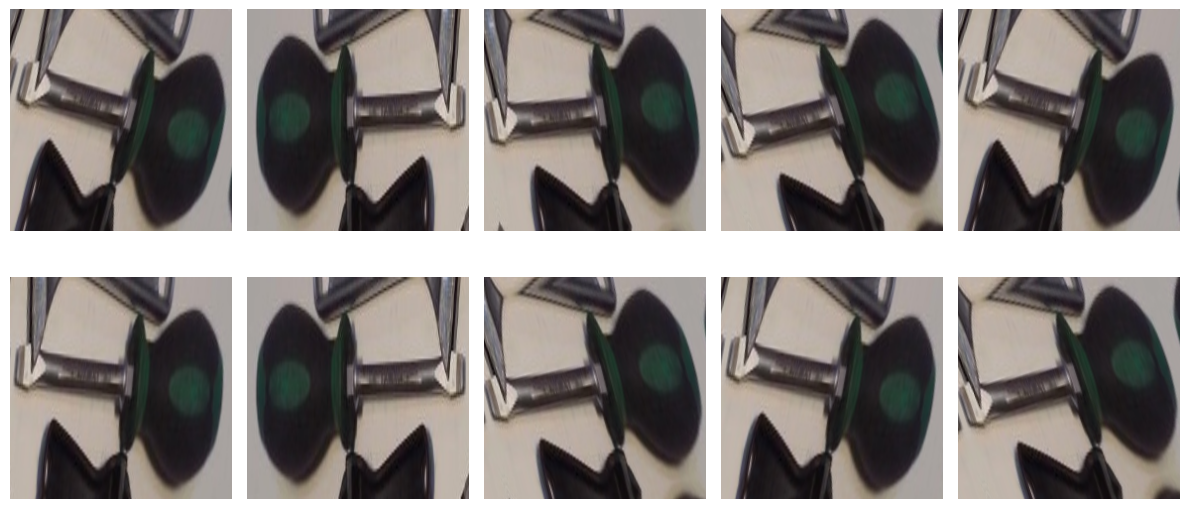

In [8]:
def visualize_augmentations(dataset, idx=8, samples=10, cols=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image, _ = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

visualize_augmentations(training_data)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


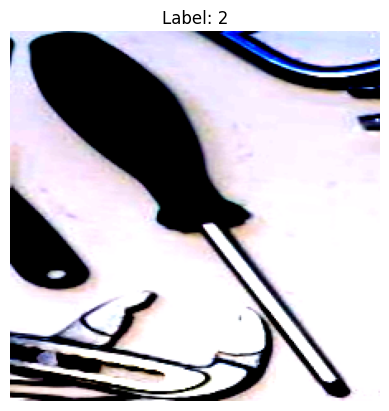

In [9]:
random_index = random.randint(0, len(training_data) - 1)

image, label = training_data[random_index]

image = image.permute(1, 2, 0)

plt.imshow(image)
plt.title("Label: {}".format(label))
plt.axis('off')
plt.show()

In [10]:
def early_stopping(val_loss):
    global best_loss, early_stopping_counter
    if val_loss < best_loss:
        best_loss = val_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            return True
    return False
def save_checkpoint(model, optimizer, epoch, val_loss, model_name):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'val_loss': val_loss
    }
    torch.save(checkpoint, f'best_{model_name}.pth')

In [41]:
resnet = models.resnext101_32x8d(pretrained=True)
for param in resnet.parameters():
    param.requires_grad = False
resnet.fc = torch.nn.Linear(resnet.fc.in_features, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.01)

In [10]:
resnet = models.resnet50(pretrained=True)
for param in resnet.parameters():
    param.requires_grad = False
resnet.fc = torch.nn.Linear(resnet.fc.in_features, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.01)

In [11]:
swin = models.swin_v2_s(pretrained=True)
for param in swin.parameters():
    param.requires_grad = False
swin.head = torch.nn.Linear(swin.head.in_features, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(swin.parameters(), lr=0.01)

In [44]:
efficientNet = models.efficientnet_v2_m(pretrained=True)
for param in efficientNet.parameters():
    param.requires_grad = False
efficientNet.classifier = torch.nn.Linear(1280, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(efficientNet.parameters(), lr=0.01)

In [13]:
swin

SwinTransformer(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): Permute()
      (2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (1): Sequential(
      (0): SwinTransformerBlockV2(
        (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (attn): ShiftedWindowAttentionV2(
          (qkv): Linear(in_features=96, out_features=288, bias=True)
          (proj): Linear(in_features=96, out_features=96, bias=True)
          (cpb_mlp): Sequential(
            (0): Linear(in_features=2, out_features=512, bias=True)
            (1): ReLU(inplace=True)
            (2): Linear(in_features=512, out_features=3, bias=False)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (0): Linear(in_features=96, out_features=384, bias=True)
          (1): GELU(approximate='

In [12]:
best_accuracy = 0
best_loss = float('inf')
early_stopping_counter = 0
patience = 4

for epoch in range(num_epochs):
    running_loss = 0.0
    
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    
    for images, labels in progress_bar:
        # images, labels = images.to(device), labels.to(device)
        # resnet = resnet.to(device)

        optimizer.zero_grad()
        
        images = images.to(device)  # Исправленная строка
        labels = labels.to(device).long()
        swin = swin.to(device)
        outputs = swin(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        progress_bar.set_postfix({"Loss": running_loss / (len(progress_bar) + 1e-6)})

    epoch_loss = running_loss / len(train_dataloader)
    epoch_loss = round(epoch_loss, 3)
    print(f"Epoch {epoch+1} Loss: {epoch_loss}")
    
    with torch.no_grad():
        val_loss = 0.0
        correct = 0
        total = 0

        all_labels = []
        all_predictions = []
        
        for images, labels in test_dataloader:
            images = images.to(device)
            labels = labels.to(device).long()
            outputs = swin(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()


            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())


            random_index = random.randint(0, images.size(0) - 1)
            prediction = predicted[random_index].item()
            label = labels[random_index].item()

        val_loss /= len(test_dataloader)
        val_loss = round(val_loss, 3)
        accuracy = correct / total

        f1 = f1_score(all_labels, all_predictions, average='macro')

        print(f"Validation Loss: {val_loss}")
        print(f"Validation Accuracy: {accuracy}")
        print(f"Validation F1 Score: {f1}")

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            save_checkpoint(swin, optimizer, epoch, val_loss, 'swin')
        
        if early_stopping(val_loss):
            print("Early Stopping!")
            break

Epoch 1 Loss: 0.96
Validation Loss: 0.836
Validation Accuracy: 0.6002673796791443
Validation F1 Score: 0.595320204295345


Epoch 2 Loss: 0.812
Validation Loss: 0.73
Validation Accuracy: 0.68048128342246
Validation F1 Score: 0.6749866735253486


Epoch 3 Loss: 0.754
Validation Loss: 0.684
Validation Accuracy: 0.7085561497326203
Validation F1 Score: 0.7093780946722124


Epoch 4 Loss: 0.726
Validation Loss: 0.763
Validation Accuracy: 0.6644385026737968
Validation F1 Score: 0.650378659804129


Epoch 5 Loss: 0.744
Validation Loss: 0.722
Validation Accuracy: 0.7165775401069518
Validation F1 Score: 0.7178167622739782


Epoch 6 Loss: 0.72
Validation Loss: 0.719
Validation Accuracy: 0.7272727272727273
Validation F1 Score: 0.7247558541117046


Epoch 7 Loss: 0.729
Validation Loss: 0.651
Validation Accuracy: 0.7647058823529411
Validation F1 Score: 0.7657012738214987


Epoch 8 Loss: 0.69
Validation Loss: 0.648
Validation Accuracy: 0.733957219251337
Validation F1 Score: 0.7315352028364875


Epoch 9 Loss: 0.707
Validation Loss: 0.632
Validation Accuracy: 0.7700534759358288
Validation F1 Score: 0.770803602005648


Epoch 10 Loss: 0.653
Validation Loss: 0.756
Validation Accuracy: 0.6938502673796791
Validation F1 Score: 0.6779712783429614


Epoch 11 Loss: 0.7
Validation Loss: 0.625
Validation Accuracy: 0.7633689839572193
Validation F1 Score: 0.762554869590163


Epoch 12 Loss: 0.666
Validation Loss: 0.788
Validation Accuracy: 0.6898395721925134
Validation F1 Score: 0.6903138528138527


Epoch 13 Loss: 0.677
Validation Loss: 0.729
Validation Accuracy: 0.7125668449197861
Validation F1 Score: 0.7127561353705962


Epoch 14 Loss: 0.652
Validation Loss: 0.629
Validation Accuracy: 0.7606951871657754
Validation F1 Score: 0.7615046440001013


Epoch 15 Loss: 0.669
Validation Loss: 0.655
Validation Accuracy: 0.7459893048128342
Validation F1 Score: 0.7464311456433478
Early Stopping!


In [13]:
checkpoint = torch.load('best_swin.pth')
swin.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
with torch.no_grad():
    correct = 0
    total = 0

    all_labels = []
    all_predictions = []

    for images, labels in test_dataloader:
        images = images.to(device)  # Исправленная строка
        labels = labels.to(device)  # Исправленная строка
        swin = swin.to(device)
        outputs = swin(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

        random_index = random.randint(0, images.size(0) - 1)
        prediction = predicted[random_index].item()
        label = labels[random_index].item()

    accuracy = correct / total
    f1 = f1_score(all_labels, all_predictions, average='macro')
    print(f"Test Accuracy: {accuracy}")
    print(f"Test F1 Score: {f1}")
    print(f"{correct}/{total}")

total_params = sum(p.numel() for p in swin.parameters() if p.requires_grad)
print(f"Total swin Parameters: {total_params}")

Test Accuracy: 0.7486631016042781
Test F1 Score: 0.7489242681595448
560/748
Total swin Parameters: 2307


In [14]:
import torch, json
from torchvision import transforms
from PIL import Image, ImageOps

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
swin = swin.to(device).eval()  # твоя обученная модель

# загрузка чекпойнта
ckpt = torch.load('best_swin.pth', map_location=device)
swin.load_state_dict(ckpt['model_state_dict'])

# имена классов (лучше сохранять их в чекпойнт при обучении)
CLASS_NAMES = ckpt.get('classes', ckpt.get('ru_classes', ckpt.get('slug_classes')))
if CLASS_NAMES is None:
    # задай вручную, если не сохранил
    CLASS_NAMES = [
      'Отвертка "-"', 'Отвертка "+"','Отвертка на смещенный крест'
    ]

# те же препроцессы, что на валидации
VAL_TF = transforms.Compose([
    transforms.Resize(256), transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])


In [18]:
import numpy as np
from pathlib import Path

def classify_crop(path):
    """path: путь к одиночному кропу инструмента"""
    img = ImageOps.exif_transpose(Image.open(path).convert('RGB'))  # поправим EXIF
    x = VAL_TF(img).unsqueeze(0).to(device)
    with torch.no_grad():
        logits = swin(x)
        probs = torch.softmax(logits, dim=1).squeeze(0)
        conf, idx = torch.max(probs, dim=0)
    return {
        "file": str(path),
        "class_id": int(idx.item()),
        "class_name": CLASS_NAMES[int(idx.item())],
        "confidence": float(conf.item())
    }

def classify_folder(folder):
    folder = Path(folder)
    out = []
    exts = {'.jpg','.jpeg','.png','.bmp','.tif','.tiff'}
    for p in sorted(folder.rglob('*')):
        if p.suffix.lower() in exts:
            out.append(classify_crop(p))
    return out


print(classify_crop("testdata/plus3.png"))
print(classify_crop("testdata/smes2.png"))
print(classify_crop("testdata/minus1.png"))
# results = classify_folder("crops_pred/val"); print(results[:3])


{'file': 'testdata/plus3.png', 'class_id': 0, 'class_name': 'Отвертка "-"', 'confidence': 0.5174537301063538}
{'file': 'testdata/smes2.png', 'class_id': 2, 'class_name': 'Отвертка на смещенный крест', 'confidence': 0.9232938289642334}
{'file': 'testdata/minus1.png', 'class_id': 1, 'class_name': 'Отвертка "+"', 'confidence': 0.891437828540802}


# Efficient

In [45]:
best_accuracy = 0
best_loss = float('inf')
early_stopping_counter = 0
patience = 4

for epoch in range(num_epochs):
    running_loss = 0.0
    
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    
    for images, labels in progress_bar:
        # images, labels = images.to(device), labels.to(device)
        # resnet = resnet.to(device)

        optimizer.zero_grad()
        
        images = images.to(device)  # Исправленная строка
        labels = labels.to(device).long()
        efficientNet = efficientNet.to(device)
        outputs = efficientNet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        progress_bar.set_postfix({"Loss": running_loss / (len(progress_bar) + 1e-6)})

    epoch_loss = running_loss / len(train_dataloader)
    epoch_loss = round(epoch_loss, 3)
    print(f"Epoch {epoch+1} Loss: {epoch_loss}")
    
    with torch.no_grad():
        val_loss = 0.0
        correct = 0
        total = 0

        all_labels = []
        all_predictions = []
        
        for images, labels in test_dataloader:
            images = images.to(device)
            labels = labels.to(device).long()
            outputs = efficientNet(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()


            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())


            random_index = random.randint(0, images.size(0) - 1)
            prediction = predicted[random_index].item()
            label = labels[random_index].item()

        val_loss /= len(test_dataloader)
        val_loss = round(val_loss, 3)
        accuracy = correct / total

        f1 = f1_score(all_labels, all_predictions, average='macro')

        print(f"Validation Loss: {val_loss}")
        print(f"Validation Accuracy: {accuracy}")
        print(f"Validation F1 Score: {f1}")

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            save_checkpoint(efficientNet, optimizer, epoch, val_loss, 'efficientNet')
        
        if early_stopping(val_loss):
            print("Early Stopping!")
            break

Epoch 1 Loss: 1.015
Validation Loss: 0.651
Validation Accuracy: 0.7619047619047619
Validation F1 Score: 0.7589615752958663


Epoch 2 Loss: 0.74
Validation Loss: 0.956
Validation Accuracy: 0.6190476190476191
Validation F1 Score: 0.621904945333937


Epoch 3 Loss: 0.712
Validation Loss: 0.875
Validation Accuracy: 0.680952380952381
Validation F1 Score: 0.6907917514922376


Epoch 4 Loss: 0.628
Validation Loss: 0.685
Validation Accuracy: 0.719047619047619
Validation F1 Score: 0.7220786149033681


Epoch 5 Loss: 0.632
Validation Loss: 0.66
Validation Accuracy: 0.7238095238095238
Validation F1 Score: 0.7298429821085799
Early Stopping!


In [47]:
checkpoint = torch.load('best_efficientNet.pth')
efficientNet.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
with torch.no_grad():
    correct = 0
    total = 0

    all_labels = []
    all_predictions = []

    for images, labels in test_dataloader:
        images = images.to(device)  # Исправленная строка
        labels = labels.to(device)  # Исправленная строка
        efficientNet = efficientNet.to(device)
        outputs = efficientNet(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

        random_index = random.randint(0, images.size(0) - 1)
        prediction = predicted[random_index].item()
        label = labels[random_index].item()

    accuracy = correct / total
    f1 = f1_score(all_labels, all_predictions, average='macro')
    print(f"Test Accuracy: {accuracy}")
    print(f"Test F1 Score: {f1}")
    print(f"{correct}/{total}")

total_params = sum(p.numel() for p in efficientNet.parameters() if p.requires_grad)
print(f"Total efficientNet Parameters: {total_params}")

Test Accuracy: 0.6619047619047619
Test F1 Score: 0.6628525487987529
139/210
Total efficientNet Parameters: 3843


# RESNET

In [42]:
best_accuracy = 0
best_loss = float('inf')
early_stopping_counter = 0
patience = 4

for epoch in range(num_epochs):
    running_loss = 0.0
    
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    
    for images, labels in progress_bar:
        # images, labels = images.to(device), labels.to(device)
        # resnet = resnet.to(device)

        optimizer.zero_grad()
        
        images = images.to(device)  # Исправленная строка
        labels = labels.to(device).long()
        resnet = resnet.to(device)
        outputs = resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        progress_bar.set_postfix({"Loss": running_loss / (len(progress_bar) + 1e-6)})

    epoch_loss = running_loss / len(train_dataloader)
    epoch_loss = round(epoch_loss, 3)
    print(f"Epoch {epoch+1} Loss: {epoch_loss}")
    
    with torch.no_grad():
        val_loss = 0.0
        correct = 0
        total = 0

        all_labels = []
        all_predictions = []
        
        for images, labels in test_dataloader:
            images = images.to(device)
            labels = labels.to(device).long()
            outputs = resnet(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()


            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())


            random_index = random.randint(0, images.size(0) - 1)
            prediction = predicted[random_index].item()
            label = labels[random_index].item()

        val_loss /= len(test_dataloader)
        val_loss = round(val_loss, 3)
        accuracy = correct / total

        f1 = f1_score(all_labels, all_predictions, average='macro')

        print(f"Validation Loss: {val_loss}")
        print(f"Validation Accuracy: {accuracy}")
        print(f"Validation F1 Score: {f1}")

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            save_checkpoint(resnet, optimizer, epoch, val_loss, 'resnet')
        
        if early_stopping(val_loss):
            print("Early Stopping!")
            break

Epoch 1 Loss: 3.287
Validation Loss: 1.498
Validation Accuracy: 0.49523809523809526
Validation F1 Score: 0.48681541582150095


Epoch 2 Loss: 0.878
Validation Loss: 0.635
Validation Accuracy: 0.719047619047619
Validation F1 Score: 0.7231121281464531


Epoch 3 Loss: 0.71
Validation Loss: 0.974
Validation Accuracy: 0.6190476190476191
Validation F1 Score: 0.5966057838660578


Epoch 4 Loss: 0.75
Validation Loss: 0.427
Validation Accuracy: 0.8380952380952381
Validation F1 Score: 0.8395556743592029


Epoch 5 Loss: 0.433
Validation Loss: 0.45
Validation Accuracy: 0.8238095238095238
Validation F1 Score: 0.8313620970665324


Epoch 6 Loss: 0.708
Validation Loss: 1.271
Validation Accuracy: 0.5952380952380952
Validation F1 Score: 0.5747602806426336


Epoch 7 Loss: 0.578
Validation Loss: 0.459
Validation Accuracy: 0.819047619047619
Validation F1 Score: 0.8151553588477373


Epoch 8 Loss: 0.617
Validation Loss: 0.935
Validation Accuracy: 0.6904761904761905
Validation F1 Score: 0.7067956660735158
Early Stopping!


In [43]:
checkpoint = torch.load('best_resnet.pth')
resnet.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
with torch.no_grad():
    correct = 0
    total = 0

    all_labels = []
    all_predictions = []

    for images, labels in test_dataloader:
        images = images.to(device)  # Исправленная строка
        labels = labels.to(device)  # Исправленная строка
        resnet = resnet.to(device)
        outputs = resnet(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

        random_index = random.randint(0, images.size(0) - 1)
        prediction = predicted[random_index].item()
        label = labels[random_index].item()

    accuracy = correct / total
    f1 = f1_score(all_labels, all_predictions, average='macro')
    print(f"Test Accuracy: {accuracy}")
    print(f"Test F1 Score: {f1}")
    print(f"{correct}/{total}")

total_params = sum(p.numel() for p in resnet.parameters() if p.requires_grad)
print(f"Total resnet Parameters: {total_params}")

Test Accuracy: 0.8761904761904762
Test F1 Score: 0.8774862902030532
184/210
Total resnet Parameters: 6147


In [24]:
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.models import swin_v2_s

# Define transformation for the image
test_transform = A.Compose(
    [
        A.Resize(224, 224),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Dictionary for class labels
class_labels = {
    0: 'empty',
    1: 'normal'
}

def get_classify_model():
    model = swin_v2_s(pretrained=False)
    model.head = nn.Linear(model.head.in_features, 2)  # Обновляем последний слой для 2 классов
    checkpoint = torch.load('images_class.pth', map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)  # Ensure the entire model is on the same device
    model.eval()
    return model

def tensor_from_images(image):
    image = test_transform(image=np.array(image))['image'].unsqueeze(0).to(device)
    return image

def predict(image_path, model):
    image = Image.open(image_path).convert('RGB')  # Ensure image is in RGB mode
    tensor = tensor_from_images(image)
    
    with torch.no_grad():
        outputs = model(tensor)
        _, preds = torch.max(outputs, 1)
        predicted_class = preds.item()
    
    return class_labels[predicted_class]


In [25]:
def predict_images_from_folder(folder_path):
    model = get_classify_model()
    results = []
    
    for image_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_name)
        
        if image_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            predicted_class = predict(image_path, model)
            results.append((image_name, predicted_class))
            print(f'{image_name} - {predicted_class}')
    
    return results

In [26]:
folder_path = 'D:/hackKalin/dataparse/test'
results = predict_images_from_folder(folder_path)

3000169.jpg - empty
3000402.jpg - empty
3001814.jpg - empty
3001960.jpg - empty
3002029.jpg - empty
3002446.jpg - empty
3005109.jpg - empty
3006307.jpg - empty
3007229.jpg - empty
__10.JPG - normal
__11.JPG - normal
__12.JPG - normal
__13.JPG - normal
__14.JPG - empty
__15.JPG - empty
__16.JPG - empty
__18.JPG - normal
__19.JPG - normal
__20.JPG - normal
__3.JPG - normal
__4.JPG - empty
__5.JPG - empty
__6.JPG - empty
__7.JPG - empty
__8.JPG - empty
__9.JPG - empty
___19.JPG - empty
___20.JPG - empty
___21.JPG - empty


In [24]:
image_path = 'D:/hackKalin/class_data/bad/1999067_1_class0.jpg'
predicted_class = predict(image_path)
print(f'The predicted class is: {predicted_class}')

The predicted class is: bad


In [28]:
image_path = 'D:/hackKalin/train_strogo/norm_animal/__110.jpg'
predicted_class = predict(image_path)
print(f'The predicted class is: {predicted_class}')

The predicted class is: good
